In this notebook, let us try and explore the data given for Zillow prize competition. Before we dive deep into the data, let us know a little more about the competition.

**Zillow:**

Zillow is an online real estate database company founded in 2006 - Wikipedia

**Zestimate:**

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today),

**Objective:**

Building a model to improve the Zestimate residual error.

The competition is in two stages. This public competition will go on till Jan 2018 and has $50,000 in prize. Please make sure to read about the [Prize details][1] and [Competition overview][2] since it is quite different in this one.

Let us first import the necessary modules.


  [1]: https://www.kaggle.com/c/zillow-prize-1#prizes
  [2]: https://www.kaggle.com/c/zillow-prize-1#Competition%20Overview

In [11]:
import numpy as np
import pandas as pd
import xgboost as xgb
import gc
import matplotlib.pyplot as plt # plotting library
import seaborn as sns # plotting, specialized for statistical fata (distributions, etc) and colorful visualization
color = sns.color_palette()

# for displaying plots inside the notebook
%matplotlib inline

# Load and prepare the data

In [12]:
print('Loading data ...')

train = pd.read_csv('../input/train_2016_v2.csv')
prop = pd.read_csv('../input/properties_2016.csv')
sample = pd.read_csv('../input/sample_submission.csv')

Loading data ...


/Users/adrienctx/anaconda/envs/py3env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
print('Binding to float32')

for c, dtype in zip(prop.columns, prop.dtypes):
	if dtype == np.float64:
		prop[c] = prop[c].astype(np.float32)

Binding to float32


In [14]:
print('Creating training set ...')

df_train = train.merge(prop, how='left', on='parcelid')

x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
y_train = df_train['logerror'].values
print(x_train.shape, y_train.shape)

train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

del df_train; gc.collect()

Creating training set ...
(90275, 55) (90275,)


46

In [15]:
split = 80000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

print('Building DMatrix...')

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

del x_train, x_valid; gc.collect()

Building DMatrix...


14

In [16]:
print('Training ...')

params = {}
params['eta'] = 0.02
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)

del d_train, d_valid

Training ...
[0]	train-mae:0.488065	valid-mae:0.48112
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.402221	valid-mae:0.395444
[20]	train-mae:0.33268	valid-mae:0.326099
[30]	train-mae:0.276518	valid-mae:0.270132
[40]	train-mae:0.231316	valid-mae:0.225213
[50]	train-mae:0.195059	valid-mae:0.189317
[60]	train-mae:0.166121	valid-mae:0.16072
[70]	train-mae:0.143116	valid-mae:0.138042
[80]	train-mae:0.124973	valid-mae:0.120214
[90]	train-mae:0.11079	valid-mae:0.106351
[100]	train-mae:0.099822	valid-mae:0.095702
[110]	train-mae:0.091454	valid-mae:0.087592
[120]	train-mae:0.085149	valid-mae:0.08158
[130]	train-mae:0.080457	valid-mae:0.077192
[140]	train-mae:0.077015	valid-mae:0.074063
[150]	train-mae:0.07451	valid-mae:0.071827
[160]	train-mae:0.072688	valid-mae:0.070245
[170]	train-mae:0.071374	valid-mae:0.069128
[180]	train-mae:0.070415	valid-mae:0.068366
[190]	train-mae:0.069715

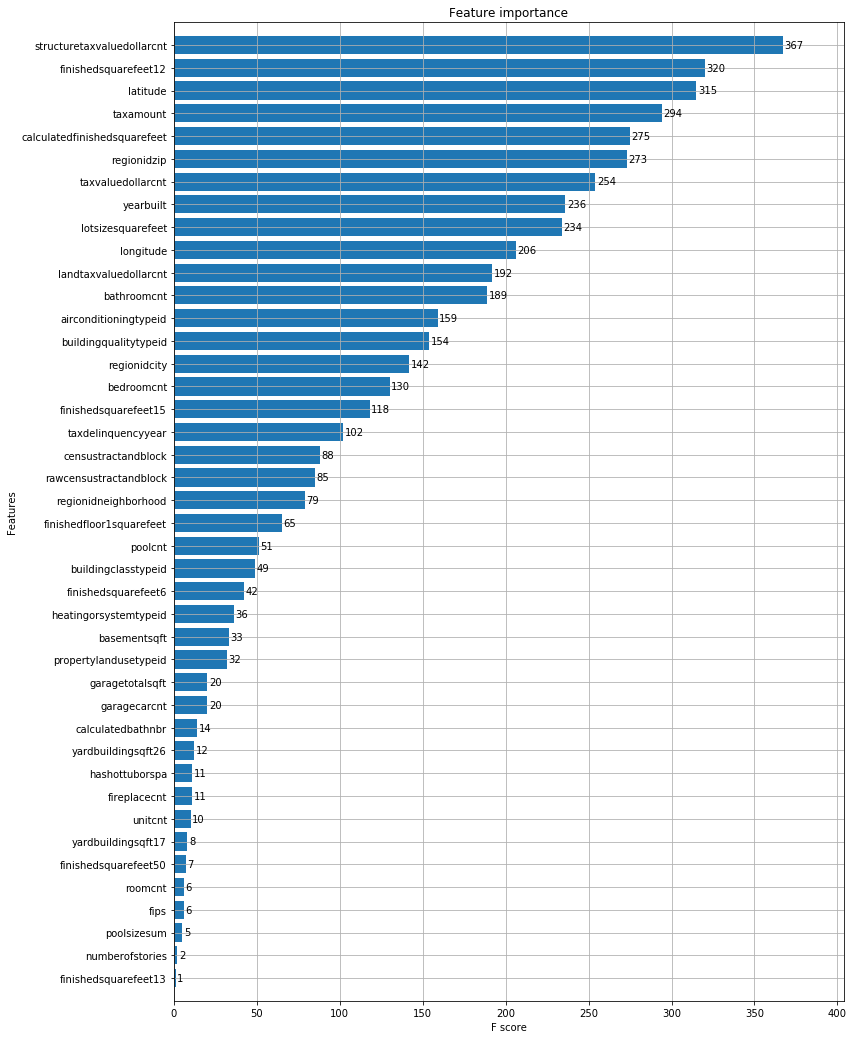

In [17]:
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf, height=0.8, ax=ax)
plt.show()

In [18]:
print('Building test set ...')

sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop, on='parcelid', how='left')

# del prop; gc.collect()

x_test = df_test.loc[:,train_columns]
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test.loc[:,c] = (x_test.loc[:,c] == True)

# del df_test, sample; gc.collect()

d_test = xgb.DMatrix(x_test)

del x_test; gc.collect()

Building test set ...


19945

In [19]:
print('Predicting on test ...')

p_test = clf.predict(d_test)

del d_test; gc.collect()

Predicting on test ...


0

In [20]:
sub = pd.read_csv('../input/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = p_test

print('Writing csv ...')
sub.to_csv('../output/xgb_starter.csv', index=False, float_format='%.4f')

Writing csv ...
